In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
import torchvision.transforms as transforms

In [2]:
torch.cuda.empty_cache()

In [3]:
!nvidia-smi

Fri Mar 22 22:17:55 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2070 ...    Off |   00000000:0A:00.0  On |                  N/A |
|  0%   49C    P8             23W /  215W |     564MiB /   8192MiB |     33%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
if torch.cuda.is_available():
    device=torch.device(type='cuda',index=0)
else:
    device=torch.device(type='cpu',index=0)
print(device)

cuda:0


In [5]:
train = datasets.MNIST("", train = True, download = True,
                       transform= transforms.Compose([transforms.ToTensor()]))
test = datasets.MNIST("", train = False, download = True,
                       transform= transforms.Compose([transforms.ToTensor()]))
print(len(train.data[0]))
print(len(test.data))

28
10000


In [6]:
batch_size=128
train_size = int(0.85 * len(train))
val_size = len(train)-train_size

train_set , val_set = random_split(train, [train_size, val_size])

train_dl=DataLoader(
    dataset=train_set,
    batch_size=batch_size,
    shuffle=True
)

valid_dl=DataLoader(
    dataset=val_set,
    batch_size=batch_size,
    shuffle=False
)

test_dl=DataLoader(
    dataset=test,
    batch_size=batch_size,
    shuffle=False
)

print("Size of training set:", len(train_set))
print("Size of validation set:", len(val_set))
print("Size of test set:", len(test))

Size of training set: 51000
Size of validation set: 9000
Size of test set: 10000


In [7]:
class AutoencoderStk1(nn.Module):
  def __init__(self):
    super(AutoencoderStk1, self).__init__()

    # self.flat = nn.Flatten()
    self.encoder = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=784, out_features=393),
        nn.BatchNorm1d(num_features=393),
        nn.ReLU(True),
        nn.Linear(in_features=393, out_features=100),
        nn.BatchNorm1d(num_features=100),
        nn.ReLU(True)
    )
    self.decoder = nn.Sequential(
        nn.Linear(in_features=100, out_features=393),
        nn.BatchNorm1d(num_features=393),
        nn.ReLU(True),
        nn.Linear(in_features=393, out_features=784),
        nn.BatchNorm1d(num_features=784),
        nn.Sigmoid()
    )

  def forward(self, x):
    # x = self.flat(x)
    # print(x.shape)
    latent = self.encoder(x)
    out = self.decoder(latent)
    return out

In [8]:
EPOCHS = 10
PRINT_AT = 100

model = AutoencoderStk1().to(device)
print(model)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

AutoencoderStk1(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=393, bias=True)
    (2): BatchNorm1d(393, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=393, out_features=100, bias=True)
    (5): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=393, bias=True)
    (1): BatchNorm1d(393, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=393, out_features=784, bias=True)
    (4): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Sigmoid()
  )
)


In [9]:
epoch_losses = []
for epoch in range(EPOCHS):
    print(f"-x-x-x-x-x-x-x-x-x-x-x-EPOCH {epoch+1}-x-x-x-x-x-x-x-x-x-x-x-")
    print("TRAINING")
    model.train()
    running_loss = 0.0
    for i, (imgs, _) in enumerate(train_dl):
        imgsT = torch.reshape(imgs,shape=[-1,784]).to(device)
        # print(imgsT.shape)
        predT = model(imgsT)
        pred = predT.view(-1, 1, 28, 28).cpu()
        loss = loss_fn(pred, imgs)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        running_loss += loss.item()
        if i % PRINT_AT == PRINT_AT-1:
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / PRINT_AT))
            running_loss = 0.0
      
    print("VALIDATING")
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i, (imgs, _) in enumerate(valid_dl):
            imgsT = torch.reshape(imgs,shape=[-1,784]).to(device)
            predT = model(imgsT)
            pred = predT.view(-1, 1, 28, 28).cpu()
            loss = loss_fn(pred, imgs)
            
            val_loss += loss.item()
            
            if i % PRINT_AT == (PRINT_AT/2)-1:
                print('[%d, %5d] valid-loss: %.3f' %(epoch + 1, i + 1, val_loss / PRINT_AT))
                val_loss = 0.0                
    val_loss /= len(valid_dl)
    
    epoch_loss = running_loss / len(train_dl)
    epoch_losses.append(epoch_loss)
    print('Epoch [%d/%d], Training Loss: %.4f, Validation Loss: %.4f' % (epoch+1, EPOCHS, epoch_loss, val_loss))

print("DONE!")

-x-x-x-x-x-x-x-x-x-x-x-EPOCH 1-x-x-x-x-x-x-x-x-x-x-x-
TRAINING
[1,   100] loss: 0.187
[1,   200] loss: 0.155
[1,   300] loss: 0.137
VALIDATING
[1,    50] valid-loss: 0.056
Epoch [1/10], Training Loss: 0.0301, Validation Loss: 0.0335
-x-x-x-x-x-x-x-x-x-x-x-EPOCH 2-x-x-x-x-x-x-x-x-x-x-x-
TRAINING
[2,   100] loss: 0.110
[2,   200] loss: 0.098
[2,   300] loss: 0.090
VALIDATING
[2,    50] valid-loss: 0.037
Epoch [2/10], Training Loss: 0.0200, Validation Loss: 0.0221
-x-x-x-x-x-x-x-x-x-x-x-EPOCH 3-x-x-x-x-x-x-x-x-x-x-x-
TRAINING
[3,   100] loss: 0.075
[3,   200] loss: 0.068
[3,   300] loss: 0.063
VALIDATING
[3,    50] valid-loss: 0.026
Epoch [3/10], Training Loss: 0.0144, Validation Loss: 0.0150
-x-x-x-x-x-x-x-x-x-x-x-EPOCH 4-x-x-x-x-x-x-x-x-x-x-x-
TRAINING
[4,   100] loss: 0.054
[4,   200] loss: 0.049
[4,   300] loss: 0.046
VALIDATING
[4,    50] valid-loss: 0.017
Epoch [4/10], Training Loss: 0.0105, Validation Loss: 0.0102
-x-x-x-x-x-x-x-x-x-x-x-EPOCH 5-x-x-x-x-x-x-x-x-x-x-x-
TRAINING
[5,  

In [10]:
# img, _ = next(iter(test_dl))
# img = img.to(device)
# print(img.shape)
# encoder1 = model.encoder
# # print(encoder1)
# latent = encoder1(img)
# print(latent.shape)

In [11]:
class AutoencoderStk2(nn.Module):
    def __init__(self):
        super(AutoencoderStk2, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=100, out_features=75),
            nn.BatchNorm1d(num_features=75),
            nn.ReLU(True),
            nn.Linear(in_features=75, out_features=50),
            nn.BatchNorm1d(num_features=50),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=50, out_features=75),
            nn.BatchNorm1d(num_features=75),
            nn.ReLU(True),
            nn.Linear(in_features=75, out_features=100),
            nn.BatchNorm1d(num_features=100),
            nn.ReLU(True)
        )
        
    def forward(self, x):
        latent = self.encoder(x)
        out = self.decoder(latent)
        return out

In [12]:
encoder1 = model.encoder
# for param in encoder1.parameters():
#     param.requires_grad = False
model1 = AutoencoderStk2().to(device)
print(model1)
optimizer1 = optim.Adam(model1.parameters())

AutoencoderStk2(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=75, bias=True)
    (1): BatchNorm1d(75, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=75, out_features=50, bias=True)
    (4): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=50, out_features=75, bias=True)
    (1): BatchNorm1d(75, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=75, out_features=100, bias=True)
    (4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
)


In [13]:
epoch_losses = []
for epoch in range(EPOCHS):
    print(f"-x-x-x-x-x-x-x-x-x-x-x-EPOCH {epoch+1}-x-x-x-x-x-x-x-x-x-x-x-")
    print("TRAINING")
    model.train()
    running_loss = 0.0
    for i, (imgs, _) in enumerate(train_dl):
        imgs = imgs.to(device)
        latent1 = encoder1(imgs)
        # latent1.to(device)
        # print(latent1.shape)
        pred = model1(latent1.detach())
        # print(pred.shape)
        loss = loss_fn(pred, latent1)
        
        loss.backward()
        optimizer1.step()
        optimizer1.zero_grad()
        
        running_loss += loss.item()
        if i % PRINT_AT == PRINT_AT-1:
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / PRINT_AT))
            running_loss = 0.0
        
    print("VALIDATING")
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i, (imgs, _) in enumerate(valid_dl):
            imgs = imgs.to(device)
            latent1 = encoder1(imgs)
            latent1.to(device)
            pred = model1(latent1.detach())
            loss = loss_fn(pred, latent1)
            
            val_loss += loss.item()
            
            if i % PRINT_AT == (PRINT_AT/2)-1:
                print('[%d, %5d] valid-loss: %.3f' %(epoch + 1, i + 1, val_loss / PRINT_AT))
                val_loss = 0.0
    val_loss /= len(valid_dl)
    
    epoch_loss = running_loss / len(train_dl)
    epoch_losses.append(epoch_loss)
    print('Epoch [%d/%d], Training Loss: %.4f, Validation Loss: %.4f' % (epoch+1, EPOCHS, epoch_loss, val_loss))
    
print("DONE!")

-x-x-x-x-x-x-x-x-x-x-x-EPOCH 1-x-x-x-x-x-x-x-x-x-x-x-
TRAINING
[1,   100] loss: 0.504
[1,   200] loss: 0.299
[1,   300] loss: 0.228
VALIDATING
[1,    50] valid-loss: 0.091
Epoch [1/10], Training Loss: 0.0461, Validation Loss: 0.0526
-x-x-x-x-x-x-x-x-x-x-x-EPOCH 2-x-x-x-x-x-x-x-x-x-x-x-
TRAINING
[2,   100] loss: 0.158
[2,   200] loss: 0.136
[2,   300] loss: 0.119
VALIDATING
[2,    50] valid-loss: 0.058
Epoch [2/10], Training Loss: 0.0265, Validation Loss: 0.0353
-x-x-x-x-x-x-x-x-x-x-x-EPOCH 3-x-x-x-x-x-x-x-x-x-x-x-
TRAINING
[3,   100] loss: 0.098
[3,   200] loss: 0.090
[3,   300] loss: 0.083
VALIDATING
[3,    50] valid-loss: 0.047
Epoch [3/10], Training Loss: 0.0195, Validation Loss: 0.0307
-x-x-x-x-x-x-x-x-x-x-x-EPOCH 4-x-x-x-x-x-x-x-x-x-x-x-
TRAINING
[4,   100] loss: 0.074
[4,   200] loss: 0.070
[4,   300] loss: 0.068
VALIDATING
[4,    50] valid-loss: 0.043
Epoch [4/10], Training Loss: 0.0161, Validation Loss: 0.0301
-x-x-x-x-x-x-x-x-x-x-x-EPOCH 5-x-x-x-x-x-x-x-x-x-x-x-
TRAINING
[5,  

In [14]:
img, _ = next(iter(test_dl))
img = img.to(device)
# pred = encoder1(img)
# pred = model1.encoder(pred)
# print(pred.shape)
print(img.shape)

torch.Size([128, 1, 28, 28])


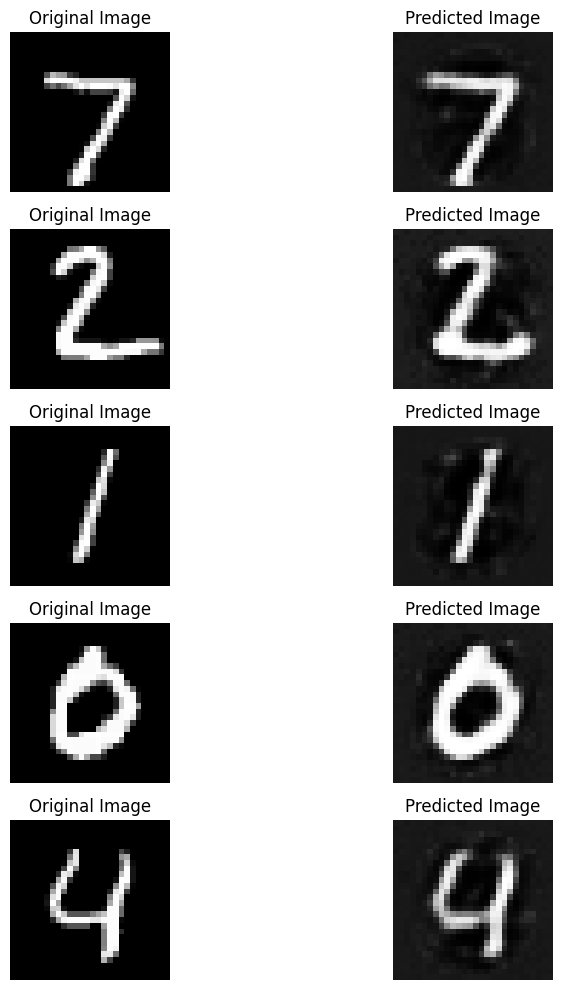

In [15]:
original_images = img.view(-1, 28, 28)

num_images = min(5, original_images.size(0)) 

fig, axes = plt.subplots(num_images, 2, figsize=(10, 10))

for i in range(num_images):
    # Plot original image
    axes[i, 0].imshow(original_images[i].squeeze().cpu().numpy(), cmap='gray')
    axes[i, 0].set_title('Original Image')
    axes[i, 0].axis('off')

    # Plot predicted image
    with torch.no_grad():
        predicted_output = encoder1(img)
        # print(predicted_output.shape)
        predicted_output = model1(predicted_output)
        # print(predicted_output.shape)
        predicted_output = model.decoder(predicted_output)
        predicted_image = predicted_output.view(-1, 28, 28)
    axes[i, 1].imshow(predicted_image[i].squeeze().cpu().numpy(), cmap='gray')
    axes[i, 1].set_title('Predicted Image')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [16]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.dense = nn.Linear(in_features=50, out_features=10)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.dense(x)
        return self.softmax(x)

In [17]:
encoder2 = model1.encoder
# for param in encoder2.parameters():
#     param.requires_grad = False
model2 = Classifier().to(device)
print(model2)
loss_fn1 = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(model2.parameters())

Classifier(
  (dense): Linear(in_features=50, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)


In [18]:
epoch_losses = []
for epoch in range(EPOCHS*10):
    print(f"-x-x-x-x-x-x-x-x-x-x-x-EPOCH {epoch+1}-x-x-x-x-x-x-x-x-x-x-x-")
    print("TRAINING")
    model.train()
    track_loss = 0.0
    num_correct=0
    for i, (imgs, labels) in enumerate(train_dl):
        imgs = imgs.to(device)
        labels = labels.to(device)
        latent1 = encoder1(imgs)
        latent2 = encoder2(latent1.detach())
        pred = model2(latent2.detach())
        
        loss = loss_fn1(pred, labels)
        track_loss+=loss.item()
        num_correct+=(torch.argmax(pred,dim=1)==labels).type(torch.float).sum().item()
        
        loss.backward()
        optimizer2.step()
        optimizer2.zero_grad()
        
        if i%PRINT_AT==0:
            running_loss = round(track_loss/(i+1), 2)
            running_acc = round((num_correct/((i+1)*batch_size))*100,2)
            print("Batch:", i+1, "/",len(train_dl), "Running Loss:",running_loss, "Running Accuracy:",running_acc)
            
    epoch_loss=track_loss/len(train_dl)
    epoch_acc=(num_correct/len(train_dl.dataset))*100
    print("Training:", "Epoch Loss:", round(epoch_loss,4), "Epoch Accuracy:", round(epoch_acc,4))
    
    print("VALIDATING")
    model.eval()
    track_loss=0
    num_correct=0
    with torch.no_grad():
        for i, (imgs, labels) in enumerate(valid_dl):
            imgs = imgs.to(device)
            labels = labels.to(device)
            latent1 = encoder1(imgs)
            latent2 = encoder2(latent1.detach())
            pred = model2(latent2.detach())
        
            loss = loss_fn1(pred, labels)
            track_loss+=loss.item()
            num_correct+=(torch.argmax(pred,dim=1)==labels).type(torch.float).sum().item()
            
            if i%PRINT_AT==0:
                running_loss = round(track_loss/(i+1), 2)
                running_acc = round((num_correct/((i+1)*batch_size))*100,2)
                print("Batch:", i+1, "/",len(valid_dl), "Running Loss:",running_loss, "Running Accuracy:",running_acc)
    epoch_loss=track_loss/len(valid_dl)
    epoch_acc=(num_correct/len(val_set))*100
    print("Validating:", "Epoch Loss:", round(epoch_loss,4), "Epoch Accuracy:", round(epoch_acc,4))
    
print("Done!")

-x-x-x-x-x-x-x-x-x-x-x-EPOCH 1-x-x-x-x-x-x-x-x-x-x-x-
TRAINING
Batch: 1 / 399 Running Loss: 2.31 Running Accuracy: 10.16
Batch: 101 / 399 Running Loss: 2.26 Running Accuracy: 23.29
Batch: 201 / 399 Running Loss: 2.22 Running Accuracy: 29.45
Batch: 301 / 399 Running Loss: 2.18 Running Accuracy: 32.55
Training: Epoch Loss: 2.1592 Epoch Accuracy: 37.0824
VALIDATING
Batch: 1 / 71 Running Loss: 2.01 Running Accuracy: 57.03
Validating: Epoch Loss: 2.0401 Epoch Accuracy: 57.4111
-x-x-x-x-x-x-x-x-x-x-x-EPOCH 2-x-x-x-x-x-x-x-x-x-x-x-
TRAINING
Batch: 1 / 399 Running Loss: 2.05 Running Accuracy: 61.72
Batch: 101 / 399 Running Loss: 2.04 Running Accuracy: 61.02
Batch: 201 / 399 Running Loss: 2.03 Running Accuracy: 64.17
Batch: 301 / 399 Running Loss: 2.01 Running Accuracy: 65.95
Training: Epoch Loss: 1.9941 Epoch Accuracy: 67.1216
VALIDATING
Batch: 1 / 71 Running Loss: 1.86 Running Accuracy: 70.31
Validating: Epoch Loss: 1.9235 Epoch Accuracy: 70.7556
-x-x-x-x-x-x-x-x-x-x-x-EPOCH 3-x-x-x-x-x-x-x-x

In [ ]:
img, labels = next(iter(test_dl))
img = img.to(device)
print(img.shape)